In [ ]:
!pip install pyspark # Installing PySpark for distributed computing capabilities, allowing us to process large datasets across multiple nodes.
!pip install torch torchvision # Installing Torch and torchvision for deep learning. Torch provides the core framework for building neural networks, and torchvision includes pre-trained models and datasets which are useful for computer vision tasks.

In [1]:
from pyspark.sql import SparkSession # Importing SparkSession from pyspark.sql to initialize Spark's functionality.
from pyspark.ml.feature import VectorAssembler # VectorAssembler is a feature transformer that merges multiple columns into a vector column.
from pyspark.ml.classification import MultilayerPerceptronClassifier # MultilayerPerceptronClassifier for creating a neural network classifier within Spark's MLlib.
from pyspark.ml.evaluation import MulticlassClassificationEvaluator # MulticlassClassificationEvaluator for evaluating the accuracy of classification models.
from pyspark.ml.linalg import DenseVector # DenseVector is a local vector, primarily used for storing features and labels in MLlib.
import torch # Importing PyTorch's core module which includes tensor computations with GPU acceleration.
import torch.nn as nn # nn module in PyTorch provides a way to efficiently build large neural networks.
import torch.optim as optim # Optim module in PyTorch includes various optimization algorithms for neural networks.
from torchvision import datasets, transforms  # Datasets and transforms from torchvision for accessing and transforming image data.
import matplotlib.pyplot as plt # matplotlib.pyplot is used for plotting graphs and visualizing data in a convenient way.v

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
from pyspark.sql import SparkSession #Importing SparkSession from pyspark.sql to initiate a Spark application. SparkSession is the entry point to programming Spark with the Dataset and DataFrame API.
from pyspark.ml.linalg import DenseVector #DenseVector is a part of pyspark.ml.linalg module, used for storing arrays of values for use in PySpark's MLlib. It's particularly useful for handling features and labels in machine learning models.
import torch #Importing PyTorch, a deep learning framework that offers flexibility and speed in building complex neural network architectures.
import torch.nn as nn #nn module from PyTorch, providing a set of classes and modules to construct neural networks. It includes layers, activation functions, and more, facilitating the building of deep learning models.
import torch.optim as optim #optim module from PyTorch, offering various optimization algorithms for neural networks. It's used to update network parameters based on gradients computed during backpropagation.
from torchvision import datasets, transforms #torchvision provides access to popular datasets, model architectures, and image transformations for computer vision. It's useful for both loading and preprocessing data for deep learning models.

In [3]:
#Initializing a SparkSession for the application named "MNISTClassification".
#This session is configured for high-performance computing with substantial memory allocation:
#"spark.executor.memory": Allocates 32 gigabytes of memory to each Spark executor. Executors are worker nodes' processes in charge of running individual tasks in a given Spark job.
#"spark.driver.memory": Assigns 32 gigabytes of memory to the Spark driver process. The driver is the central coordinator, responsible for managing the distribution of data and tasks among the executors.
#"spark.driver.maxResultSize": Sets the maximum size of serialized results that the driver can receive at 2 gigabytes. This helps in managing the amount of data transferred between executors and the driver, preventing OutOfMemory errors.
# These settings are particularly useful for resource-intensive applications like processing and classifying MNIST dataset images, which can require significant computational power and memory.
spark = SparkSession.builder \
    .appName("MNISTClassification") \
    .config("spark.executor.memory", "32g") \
    .config("spark.driver.memory", "32g") \
    .config("spark.driver.maxResultSize", "2g") \
    .getOrCreate()

24/04/07 09:54:54 WARN Utils: Your hostname, muhammad-VM resolves to a loopback address: 127.0.1.1; using 10.0.2.15 instead (on interface enp0s3)
24/04/07 09:54:54 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/04/07 09:54:55 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [5]:
#Creating a transformation pipeline for preprocessing image data, particularly useful for image datasets like MNIST.
#The transformation consists of two steps:
#1. `transforms.ToTensor()`: Converts the input image to a PyTorch tensor. This is necessary because PyTorch models expect input data in tensor format. It also scales the image's pixel intensity values from [0, 255] to [0, 1].
#2. `transforms.Normalize((0.1307,), (0.3081,))`: Normalizes the tensor image with mean = 0.1307 and standard deviation = 0.3081. These values are specific to the MNIST dataset and are used to standardize the pixel values, improving the convergence behavior of neural networks by ensuring that the input data has a mean of 0 and a standard deviation of 1.
#This transformation is crucial for preparing the MNIST dataset for training and testing in neural network models.
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

In [6]:
#Loading the MNIST dataset for training and testing purposes using PyTorch's torchvision.datasets module.
#The MNIST dataset consists of 28x28 pixel grayscale images of handwritten digits (0 through 9) and is commonly used for training various image processing systems.
# Parameters for both training and test datasets:
#-root: Specifies the directory where the MNIST dataset will be stored. './data' indicates a folder named 'data' in the current directory.
#-transform: Applies the previously defined transformation pipeline to the dataset images, converting them to normalized tensors. This ensures the data is in the correct format and scale for neural network models.
#-download: When set to True, the dataset will be downloaded from the internet if it's not already available at the specified 'root' directory. This is only needed for the training dataset here.
#The 'train' parameter differentiates between loading the training dataset (train=True) and the test dataset (train=False):
#-For training data, 'train=True' loads the subset of the dataset intended for training the model.
#-For testing data, 'train=False' loads the subset intended for evaluating the model's performance.
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform)


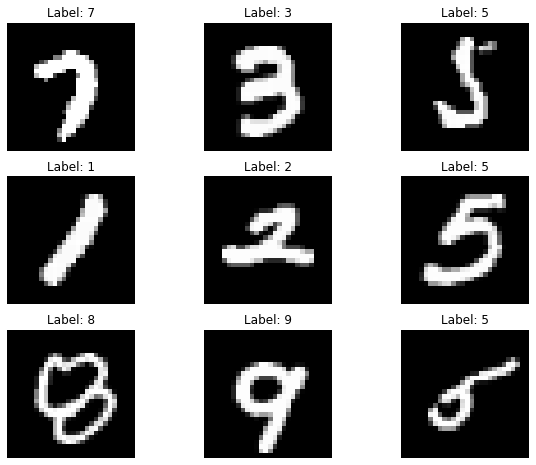

In [7]:
# Creating a figure to display images from the MNIST training dataset with matplotlib. 
# This visual representation helps in understanding the diversity and characteristics of the dataset.
figure = plt.figure(figsize=(10, 8)) # Setting the size of the figure to 10x8 inches for better visibility.
cols, rows = 3, 3 #Defining the grid layout to display the images. Here, we choose to display 3 columns and 3 rows, totaling 9 images.
for i in range(1, cols * rows + 1): #Looping through the number of positions in the grid (cols * rows = 9) to place each image.
    sample_idx = torch.randint(len(train_dataset), size=(1,)).item() #Randomly selecting an index to pick an image from the training dataset.
    img, label = train_dataset[sample_idx] #Retrieving the image and its corresponding label using the randomly selected index.
    figure.add_subplot(rows, cols, i)#Adding a subplot to the figure at the ith position in the grid.
    plt.title(f'Label: {label}') #Setting the title of the subplot to display the image's label. This helps in identifying the digit the image represents.
    plt.axis("off") #Turning off the axis to ensure the focus is solely on the image without any distracting ticks or labels.
    plt.imshow(img.squeeze(), cmap="gray") #Displaying the image in grayscale to match the original format of MNIST images. The `squeeze()` function removes any singleton dimensions to ensure the image can be displayed properly.
plt.show() # Displaying the figure with all the subplots.

In [8]:
# Converting the MNIST dataset from PyTorch tensors to PySpark's DenseVector format.
# This transformation is crucial for integrating PyTorch's data handling capabilities with PySpark's MLlib for machine learning tasks.
# The MNIST dataset, primarily used for image classification tasks, consists of images represented as PyTorch tensors in the `train_dataset` and `test_dataset`.
# For each image in the datasets:
# The `features` tensor, representing the image, is reshaped into a one-dimensional vector using `view(-1)`. This step flattens the 2D image (28x28 pixels) into a 1D array of 784 elements, suitable for input into machine learning models.
# The `.numpy()` method converts the tensor into a NumPy array, a necessary step before creating a DenseVector, as PySpark's DenseVector does not directly accept PyTorch tensors.
# `DenseVector()` then converts the NumPy array into a PySpark DenseVector, making the data compatible with PySpark's DataFrame API and MLlib.
# The `label` for each image, indicating the digit it represents (0-9), is paired with its corresponding DenseVector in a tuple. This pairing forms the final dataset structure needed for supervised learning tasks in PySpark.
# The resulting `train_data` and `test_data` lists consist of tuples, each containing a DenseVector of features and a corresponding label. These datasets are now ready for use in PySpark's machine learning pipelines.
train_data = [(DenseVector(features.view(-1).numpy()), label) for features, label in train_dataset]
test_data = [(DenseVector(features.view(-1).numpy()), label) for features, label in test_dataset]


In [9]:
# Converting the training and testing datasets into Resilient Distributed Datasets (RDDs) and then to DataFrames for use in Spark's MLlib.
# This process is essential for leveraging Spark's distributed computing capabilities, allowing for scalable machine learning tasks.
# Parallelizing the datasets into RDDs:
# - `spark.sparkContext.parallelize` method is used to distribute the `train_data` and `test_data` across the Spark cluster.
# - `numSlices` parameter controls the number of partitions to cut the dataset into. This can affect the performance of the parallel operations. 
#  - For the training dataset, `numSlices=10` is used, aiming for a balance between parallelism and overhead.
#  - For the testing dataset, `numSlices=2` is selected, considering it might be smaller or require less parallelism.
# These RDDs allow for distributed operations but do not directly support the DataFrame operations and MLlib functionalities that are desired.
# Converting RDDs to DataFrames:
# - The `toDF` method converts the RDDs to DataFrames, specifying the column names ["features", "label"]. 
# - "features" column contains the DenseVector representing the flattened image data.
# - "label" column contains the corresponding digit label for each image.
# DataFrames offer more functionalities, are easier to work with for data analysis, and integrate seamlessly with Spark SQL and MLlib.
train_rdd = spark.sparkContext.parallelize(train_data, numSlices=10)
test_rdd = spark.sparkContext.parallelize(test_data, numSlices=2)
# Creating DataFrames from RDDs for both training and testing datasets.
train_df = train_rdd.toDF(["features", "label"])
test_df = test_rdd.toDF(["features", "label"])

24/04/07 09:55:25 WARN TaskSetManager: Stage 0 contains a task of very large size (31451 KiB). The maximum recommended task size is 1000 KiB.
/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
24/04/07 09:55:28 WARN TaskSetManager: Stage 1 contains a task of very large size (31451 KiB). The maximum recommended task size is 1000 KiB.
/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [10]:
# Convert Spark DataFrames to PyTorch DataLoader
train_data = train_df.select("features", "label").rdd.map(lambda x: (x.features.toArray(), x.label)).collect()
test_data = test_df.select("features", "label").rdd.map(lambda x: (x.features.toArray(), x.label)).collect()

24/04/07 09:55:33 WARN TaskSetManager: Stage 2 contains a task of very large size (31451 KiB). The maximum recommended task size is 1000 KiB.
/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of

In [11]:
# Converting the training and testing datasets from PySpark's DenseVector format back into PyTorch tensors.
# This conversion is necessary for utilizing the datasets with PyTorch's deep learning models and functions.
# For both training and testing datasets:
# - A list comprehension extracts the features (originally DenseVectors) and labels from each dataset.
# - The features are converted to PyTorch tensors and cast to float type (`float()`) because PyTorch models typically expect floating-point inputs for calculations.
# - The labels are also converted to PyTorch tensors but are cast to long type (`long()`) since labels are used as integer indices, and PyTorch expects long integers for such cases.
# `train_x` and `test_x` store the features tensors for training and testing, respectively. These tensors are suitable for feeding into neural network models as input data.
# `train_y` and `test_y` hold the labels tensors for training and testing, respectively. These are used to compare the model's predictions against the actual values during the training and evaluation processes.
train_x = torch.tensor([item[0] for item in train_data]).float()#Extracting and converting training features
train_y = torch.tensor([item[1] for item in train_data]).long()#Extracting and converting training labels
test_x = torch.tensor([item[0] for item in test_data]).float()#Extracting and converting testing features
test_y = torch.tensor([item[1] for item in test_data]).long()#Extracting and converting testing labels


/tmp/ipykernel_2196/1080352182.py:9: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:275.)
  train_x = torch.tensor([item[0] for item in train_data]).float()#Extracting and converting training features


In [12]:
# Importing essential libraries and modules for building and training deep learning models using PyTorch, preprocessing datasets, and evaluating model performance.
import torch #torch: The main PyTorch library for tensor computation and automatic differentiation. It's the backbone for building neural networks and performing tensor operations.
import torch.nn as nn #torch.nn: A sub-module of PyTorch that provides layers and utilities to construct neural networks. It includes predefined layers, loss functions, and other helpful tools for model building.
import torch.optim as optim #torch.optim: A sub-module that implements various optimization algorithms for training neural networks. These algorithms adjust model parameters to minimize the loss function.
from torchvision import datasets, transforms #torchvision: An extension of PyTorch that provides access to popular datasets, model architectures, and image transformations for computer vision applications.
from torch.utils.data import DataLoader, TensorDataset #torch.utils.data.DataLoader: A utility that wraps a dataset and provides an iterable over the dataset. It supports automatic batching, sampling, shuffling, and multiprocess data loading.
from sklearn.metrics import confusion_matrix #sklearn.metrics.confusion_matrix: A function from scikit-learn, a machine learning library for Python. The confusion matrix is a tool for evaluating the accuracy of classification models by comparing the true labels with the predictions.

In [13]:
train_dataset = TensorDataset(train_x, train_y)#Creating the training dataset by pairing the training features and labels.
test_dataset = TensorDataset(test_x, test_y)#Creating the testing dataset by pairing the testing features and labels.

In [14]:
# Initializing DataLoader instances for the training and testing datasets using PyTorch.
# DataLoader provides an iterable over the given dataset, supporting automatic batching, sampling, shuffling, and multiprocess data loading.
# For the training data:
# - `train_dataset` is the TensorDataset containing the training data's features and labels.
# - `batch_size=128` specifies the number of samples to load per batch. This size is chosen based on the memory capacity and the need to balance computational efficiency with model performance.
# - `shuffle=True` indicates that the data should be shuffled at every epoch before the batching. Shuffling helps in reducing overfitting by ensuring that the model does not learn the order of the training data.
# For the testing data:
# - `test_dataset` is the TensorDataset for the testing data.
# - The batch size is also set to 128 for consistency with the training loader, ensuring that the testing phase uses the same batch size.
# - Shuffling is not needed for testing, so it is omitted. The goal during testing is to evaluate the model's performance on a fixed set of data.
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128)


In [15]:
# Define the neural network architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Create an instance of the model
model = Net()

In [16]:
# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model
num_epochs = 10
for epoch in range(num_epochs):
    running_loss = 0.0
    for i, (inputs, labels) in enumerate(train_loader):
        inputs = inputs.view(inputs.shape[0], -1)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")


Epoch [1/10], Loss: 0.3164
Epoch [2/10], Loss: 0.1314
Epoch [3/10], Loss: 0.0889
Epoch [4/10], Loss: 0.0666
Epoch [5/10], Loss: 0.0524
Epoch [6/10], Loss: 0.0421
Epoch [7/10], Loss: 0.0337
Epoch [8/10], Loss: 0.0293
Epoch [9/10], Loss: 0.0254
Epoch [10/10], Loss: 0.0211


In [17]:
# Evaluate the model
model.eval()
y_true = []
y_pred = []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.view(inputs.shape[0], -1)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        y_true.extend(labels.numpy())
        y_pred.extend(predicted.numpy())

# Calculate accuracy and confusion matrix
accuracy = (torch.tensor(y_pred) == torch.tensor(y_true)).float().mean()
print(f"Test Accuracy: {accuracy.item():.4f}")

cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(cm)

Test Accuracy: 0.9756
Confusion Matrix:
[[ 961    1    1    0    2    1    5    2    4    3]
 [   0 1124    4    0    0    0    3    0    4    0]
 [   3    1 1014    2    2    0    2    2    6    0]
 [   0    0    4  988    0    3    0    2   12    1]
 [   0    0    2    1  964    0    6    1    1    7]
 [   3    0    0   10    2  863    7    0    6    1]
 [   3    3    1    0    6    2  940    0    3    0]
 [   1    8   21    0    3    0    1  982    4    8]
 [   5    0    1    0    2    1    1    3  959    2]
 [   2    4    1    5   12    5    1    5   13  961]]


In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

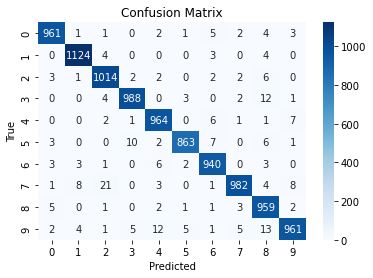

In [19]:
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()